In [3]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example dataset and simple NN example for the IceCube neutrino kaggle challenge

In [4]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tqdm
from pyarrow import dataset

In [5]:
%matplotlib inline

In [12]:
geometry = np.load('geometry.npy')

In [13]:
data_dir = '/home/storage/hans/datasets/kaggle/eller/l2_kaggle_merged/'
data = dataset.dataset([data_dir+'Level2_NuMu_NuGenCCNC.022011.0033xx.parquet', data_dir+'Level2_NuE_NuGenCCNC.022014.0000xx.parquet'])
batches = data.to_batches(batch_size=100_000)

we'll just use one batch for now

In [14]:
a = ak.from_arrow(next(batches))

## Inspecting the data

this is a very small example dataset (38769). For a real challenge, we can supply much more

[77, 344, 377, 571, 703, 709, 709, 709, ... 4424, 4426, 4427, 4429, 4689, 4750, 5052]


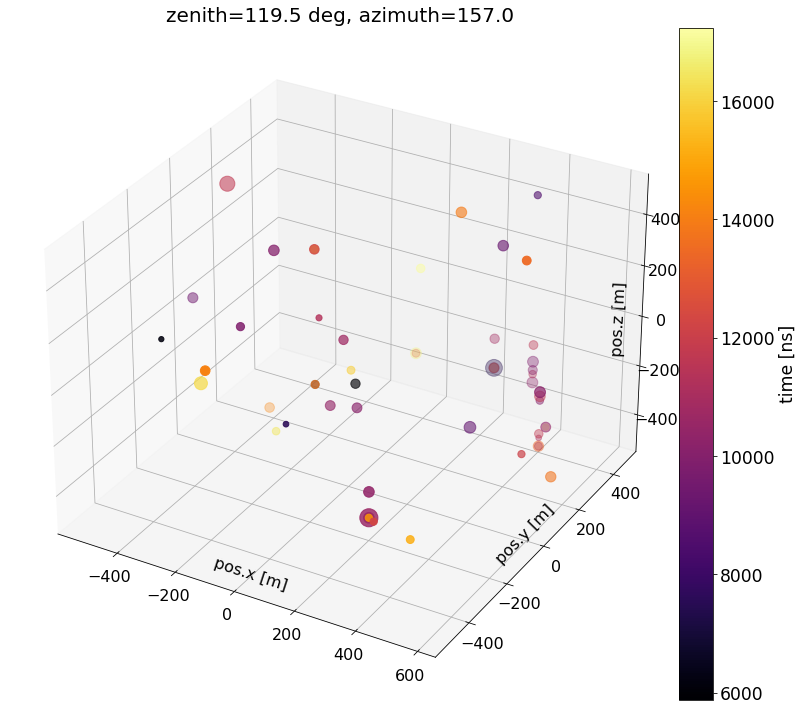

In [81]:
ev_idx = 2
event = a[ev_idx]
print(event.features.sensor_idx)
mask = (~event.features.flag) | (event.features.flag)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(projection='3d')
ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-35)
ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-35)
ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-35)
pos = geometry[event.features.sensor_idx]
im = ax.scatter(pos[:, 0][mask], pos[:, 1][mask], pos[:, 2][mask], s=event.features.charge[mask]*100, c=event.features.time[mask], cmap='inferno')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
cb = plt.colorbar(im, orientation="vertical", pad=0.0)
cb.set_label(label='time [ns]', size='xx-large')
cb.ax.tick_params(labelsize='xx-large')
plt.title(f"zenith={event.labels.zenith/np.pi*180:.1f} deg, azimuth={event.labels.azimuth/np.pi*180:.1f} ", fontsize=20)
plt.tight_layout()
plt.savefig(f"event_{ev_idx}.png", dpi=300)

In [91]:
print(np.amax(event.features.time))

17241.0


## Simple fully connected NN approach

Since the data is ragged, we aggregate some features into a fixed number of time windows per event

In [16]:
%%time
n_evts = len(a)
n_q = 10

flat_features = np.empty((n_evts, n_q, 6))

for i in tqdm.tqdm(range(n_evts)):
    event = a[i]
    pos = geometry[event.features.sensor_idx]
    bins = np.quantile(event.features.time, np.linspace(0, 1, n_q+1))
    indices = np.clip(np.digitize(event.features.time, bins), 1, n_q) - 1

    flat_features[i, :, 0] = np.bincount(indices)
    flat_features[i, :, 1] = np.bincount(indices, weights=event.features.charge)
    flat_features[i, :, 2] = np.bincount(indices, weights=pos[:, 0])
    flat_features[i, :, 3] = np.bincount(indices, weights=pos[:, 1])
    flat_features[i, :, 4] = np.bincount(indices, weights=pos[:, 2])
    flat_features[i, :, 5] = np.bincount(indices, weights=event.features.time)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        flat_features[i, :, 2:] /= flat_features[i, :, 1][:, np.newaxis]
        
    flat_features[np.isnan(flat_features)] = 0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [10:00<00:00, 166.66it/s]

CPU times: user 9min 59s, sys: 2.67 s, total: 10min 2s
Wall time: 10min


In [101]:
np.save("flat_features.npy", flat_features)

In [103]:
! ls -lah *.npy

-rw-rw-r-- 1 hans hans  46M Aug  4 17:36 flat_features.npy
-rw-rw-r-- 1 hans hans 122K Aug  4 15:12 geometry.npy


normalize the data by simple scaling:

In [17]:
mu, std = np.mean(flat_features, axis=0), np.std(flat_features, axis=0)

In [18]:
x = (flat_features - mu) / std

In [19]:
y = a[:n_evts].labels.to_numpy().view('<f8').reshape(-1, 2)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

Here we choose as the training loss the angular distance between truth and prediction

In [21]:
def loss(y1, y2):
    '''
    calculate angular distance between y1 and y2
    y1 : vector of (az, zen)
    y2 : vector of (az, zen)
    '''
    
    sa1 = tf.math.sin(y1[:, 0])
    ca1 = tf.math.cos(y1[:, 0])
    sz1 = tf.math.sin(y1[:, 1])
    cz1 = tf.math.cos(y1[:, 1])
    
    sa2 = tf.math.sin(y2[:, 0])
    ca2 = tf.math.cos(y2[:, 0])
    sz2 = tf.math.sin(y2[:, 1])
    cz2 = tf.math.cos(y2[:, 1])
    
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    r1 = tf.maximum(0., y1[:, 0] - 2*np.pi) + tf.maximum(0., - y1[:, 0])
    r2 = tf.maximum(0., y1[:, 1] - np.pi) + tf.maximum(0., - y1[:, 1])    
    r3 = tf.maximum(0., y2[:, 0] - 2*np.pi) + tf.maximum(0., - y2[:, 0])
    r4 = tf.maximum(0., y2[:, 1] - np.pi) + tf.maximum(0., - y2[:, 1])
    a = tf.math.acos(tf.clip_by_value(scalar_prod, -0.99999, 0.99999))
    return tf.reduce_mean(a + r1**2 + r2**2 + r3**2 + r4**2)

Vanilla fully connected NN:

In [22]:
inp = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Flatten()(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(50, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(50, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(50, activation="relu")(x)
out = tf.keras.layers.Dense(2, activation="linear")(x)
model = tf.keras.Model(inputs=[inp], outputs=[out])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 6)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60)                240       
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)               

2022-08-04 15:32:47.765007: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-04 15:32:47.788390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 15:32:47.788568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 2060 SUPER computeCapability: 7.5
coreClock: 1.665GHz coreCount: 34 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-04 15:32:47.788584: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-04 15:32:47.812173: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-04 15:32:47.825933: I tensorflow/stream_execut

In [23]:
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(0.001))

In [24]:
history = model.fit(x_train, y_train, epochs=50, batch_size=1024, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50


2022-08-04 15:34:05.961811: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


88/88 [==============================] - 0s 5ms/step - loss: 1.5119 - val_loss: 1.3508
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 1.2642 - val_loss: 1.2579
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 1.1893 - val_loss: 1.1750
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 1.1355 - val_loss: 1.1185
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 1.0978 - val_loss: 1.0900
Epoch 6/50
88/88 [==============================] - 0s 4ms/step - loss: 1.0708 - val_loss: 1.0676
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 1.0518 - val_loss: 1.0482
Epoch 8/50
88/88 [==============================] - 0s 3ms/step - loss: 1.0370 - val_loss: 1.0363
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 1.0255 - val_loss: 1.0281
Epoch 10/50
88/88 [==============================] - 0s 3ms/step - loss: 1.0153 - val_loss: 1.0229
Epoch 11/50
88/88 [===========

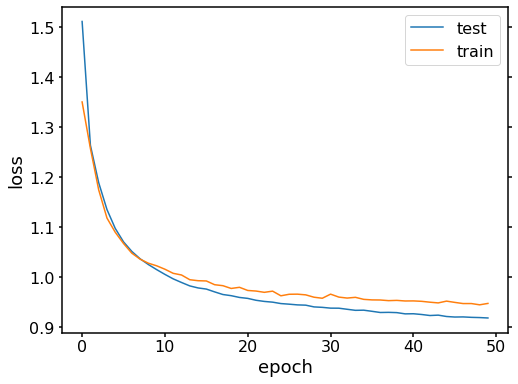

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(history.history['loss'], label='test')
ax.plot(history.history['val_loss'], label='train')
ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('loss', fontsize=18)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.5)
      ax.spines[axis].set_color('0.0')

ax.legend(fontsize=16, loc='upper right')

plt.savefig("loss.png", dpi=300)

## Performance

In [26]:
pred_test = model.predict(x_test)
pred_train = model.predict(x_train)

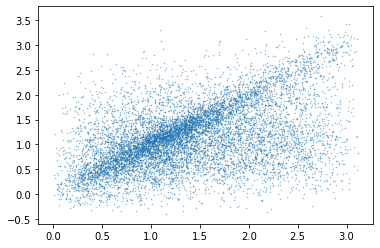

In [27]:
plt.plot(y_test[:,1], pred_test[:,1], '.', ms=1, alpha=0.5)
#plt.plot(y_train[:,1], pred_train[:,1], '.', ms=1, alpha=0.1)

(Azimuth is a circular quantity, so 0 and 2 pi is the same)

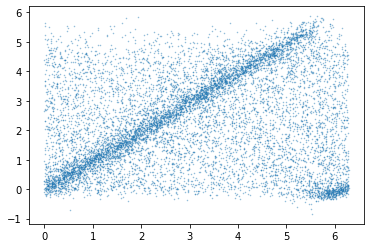

In [28]:
plt.plot(y_test[:,0], pred_test[:,0], '.', ms=1, alpha=0.5)
#plt.plot(y_train[:,0], pred_train[:,0], '.', ms=1, alpha=0.1)

In [29]:
def angular_dist(y1, y2):
    '''
    calculate angular distance between y1 and y2
    y1 : vector of (az, zen)
    y2 : vector of (az, zen)
    '''
    
    sa1 = np.sin(y1[:, 0])
    ca1 = np.cos(y1[:, 0])
    sz1 = np.sin(y1[:, 1])
    cz1 = np.cos(y1[:, 1])
    
    sa2 = np.sin(y2[:, 0])
    ca2 = np.cos(y2[:, 0])
    sz2 = np.sin(y2[:, 1])
    cz2 = np.cos(y2[:, 1])
    
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    return np.arccos(scalar_prod)

here we plot some resolutions on the directional angles:

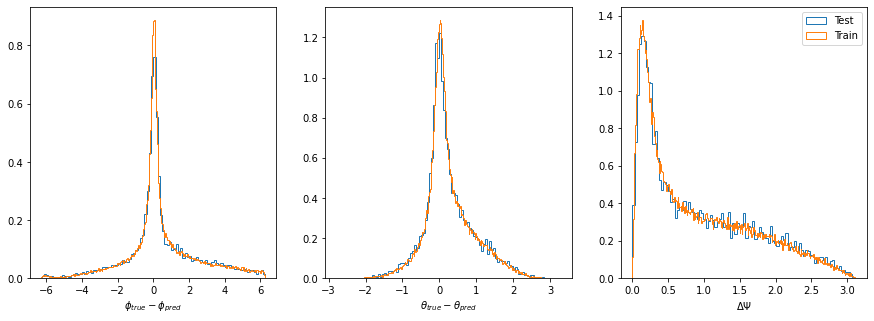

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))


ax[0].hist((y_test[:,0] - pred_test[:,0]%(2*np.pi)), bins=100, density=True, histtype="step", label='Test');
ax[0].hist(y_train[:,0] - pred_train[:,0]%(2*np.pi), bins=300, density=True, histtype="step", label='Train');
ax[0].set_xlabel(r'$\phi_{true} - \phi_{pred}$')


ax[1].hist(y_test[:,1] - pred_test[:,1], bins=100, density=True, histtype="step", label='Test');
ax[1].hist(y_train[:,1] - pred_train[:,1], bins=300, density=True, histtype="step", label='Train');
ax[1].set_xlabel(r'$\theta_{true} - \theta_{pred}$')

ax[2].hist(angular_dist(y_test, pred_test), bins=100, density=True, histtype="step", label='Test');
ax[2].hist(angular_dist(y_train, pred_train), bins=300, density=True, histtype="step", label='Train');
ax[2].set_xlabel(r'$\Delta\Psi$')

plt.legend()



38.478659079409994


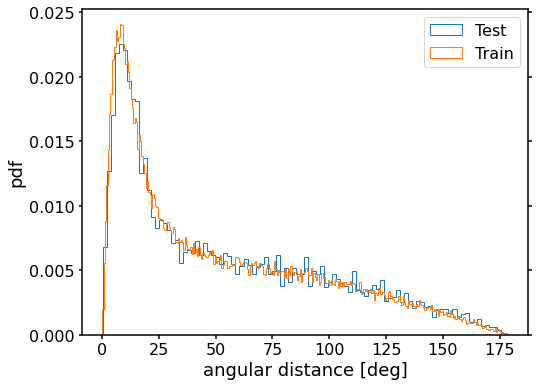

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.hist(angular_dist(y_test, pred_test)/np.pi*180, bins=100, density=True, histtype="step", label='Test');
ax.hist(angular_dist(y_train, pred_train)/np.pi*180, bins=300, density=True, histtype="step", label='Train')

ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_ticks_position('both')
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(1.5)
      ax.spines[axis].set_color('0.0')

ax.set_xlabel('angular distance [deg]', fontsize=18)
ax.set_ylabel('pdf', fontsize=18)
ax.legend(fontsize=16, loc='upper right')

print(np.median(angular_dist(y_train, pred_train)/np.pi*180,))
plt.savefig("ang_dist.png", dpi=300)



In [31]:
np.mean(angular_dist(y_test, pred_test))

0.9454712213843844

In [32]:
np.mean(angular_dist(y_train, pred_train))

0.9063627456015482

In [33]:
from scipy import stats

In [34]:
stats.ks_2samp(angular_dist(y_train, pred_train), angular_dist(y_test, pred_test))

Ks_2sampResult(statistic=0.023288888888888915, pvalue=0.00011511774985454517)